In [1]:
import numpy as np
import scipy.stats as scs
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import learning_curve

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier

from xgboost import XGBClassifier

import warnings
warnings.filterwarnings('ignore')

pd.set_option('precision', 2)
pd.options.display.max_columns = None # Show all columns
pd.options.display.max_rows = None # Show all columns

###  1. 数据统一录入至Excel表格

In [73]:
data = pd.read_excel('./studata.xlsx')
def devide_grade(x):
    return 0 if x=='C.2014年' else 1
data['GRADE'] = data['GRADE'].apply(devide_grade)

def devide_pro(x):
    if x=='A.临床医学':
        result = 0
    elif x == 'B.药学':
        result = 1
    elif x == 'C.生物工程':
        result = 2
    else:
        result = 3
    return result
data['PRO'] = data['PRO'].apply(devide_pro)

def devide_sex(x):
    return 0 if x=='A.男' else 1
data['SEX'] = data['SEX'].apply(devide_sex)


def devide_water(x):
    if x=='A.矿泉水':
        result = 0
    elif x == 'B.可乐':
        result = 1
    elif x == 'C.脉动':
        result = 2
    else:
        result = 3
    return result
data['WATER'] = data['WATER'].apply(devide_water)

def devide_step(x):
    if x=='A.建议其把你买的水喝下去':
        result = 0
    elif x == 'B.检查其生命体征':
        result = 1
    elif x == 'C.测量其体重':
        result = 2
    else:
        result = 3
    return result
data['STEP'] = data['STEP'].apply(devide_step)

def devide_dis(x):
    if x=='A.休克':
        result = 0
    elif x == 'B.缺水':
        result = 1
    elif x == 'C.脱水':
        result = 2
    else:
        result = 3
    return result
data['DIS'] = data['DIS'].apply(devide_dis)

def devide_seq(x):
    if x=='A.钾钙一起补':
        result = 0
    elif x == 'B.钾钙都不补':
        result = 1
    elif x == 'C.先补钾后补钙':
        result = 2
    else:
        result = 3
    return result
data['SEQ'] = data['SEQ'].apply(devide_seq)

data.astype('category').describe()

,TIME,GRADE,PRO,SEX,WATER,STEP,DIS,SEQ
count,297,297,297,297,297,297,297,297
unique,131,2,4,2,4,4,4,4
top,85,1,0,1,0,1,0,2
freq,7,282,195,195,156,167,167,220


#### Pretest for best classifier.

In [74]:
data = data[data['PRO']<1]
data = data[data['GRADE']==1]

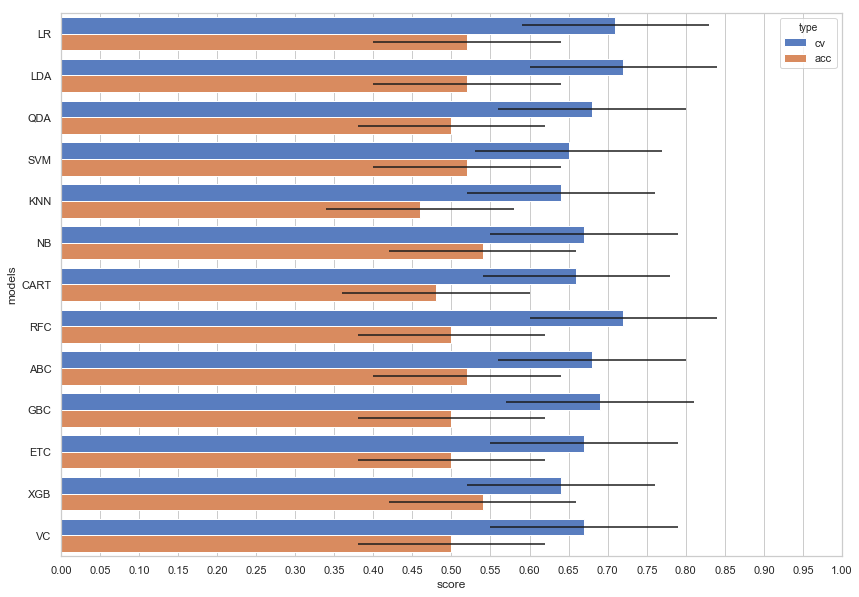

In [76]:
X, y = data.values[:, [4,5,6,7]], data.values[:, 3]

X_train, X_test, y_train, y_test = train_test_split(X, y)

models = {
    'LR': LogisticRegression(solver='liblinear', multi_class='auto'),
    'LDA': LinearDiscriminantAnalysis(),
    'QDA': QuadraticDiscriminantAnalysis(),
    'SVM': SVC(gamma='scale'),
    'KNN': KNeighborsClassifier(),
    'NB': GaussianNB(),
    'CART': DecisionTreeClassifier(),
    'RFC': RandomForestClassifier(n_estimators=100),
    'ABC': AdaBoostClassifier(),
    'GBC': GradientBoostingClassifier(),
    'ETC': ExtraTreesClassifier(n_estimators=100),
    'XGB': XGBClassifier()
}

models['VC'] = VotingClassifier(estimators=[
    ('lr', models['LR']), ('lda', models['LDA']), ('qda', models['QDA']),
    ('svm', models['SVM']),('knn', models['KNN']), ('nb', models['NB']), 
    ('cart', models['CART']), ('rfc', models['RFC']), ('abc', models['ABC']),
    ('gbc', models['GBC']), ('etc', models['ETC']), 
    ('xgb', models['XGB'])], voting='hard')

kfold = StratifiedKFold(n_splits=10)
cv_result = []

for key in models:
        models[key].fit(X_train, y_train)
        cv_score = cross_val_score(
            models[key], X_train, y_train, scoring="accuracy", cv=kfold)
        cv_means = round(cv_score.mean(), 2)
        cv_std = round(cv_score.std(), 2)
        acc_score = round(models[key].score(X_test, y_test), 2)
        cvresult = {'models': key, 'score': cv_means, 'type': 'cv'}
        cv_result.append(cvresult)
        cvresult = {'models': key, 'score': acc_score, 'type': 'acc'}
        cv_result.append(cvresult)
    #     print(confusion_matrix(y_test, models[key].predict(X_test)))
    #     print(key)
    #     print('='*80)
    #     print(classification_report(y_test, models[key].predict(X_test)))
    #     print(key,'====',models[key].get_params())

cv_results = pd.DataFrame(cv_result)

plt.figure(figsize=(14, 10))
sns.set(style="whitegrid")
# g = sns.barplot(x='score', y='models', hue='type', data=cv_results, palette="muted");
g = sns.barplot(x='score', y='models', hue='type', data=cv_results, **{'xerr': cv_std}, palette='muted')
g.set_xticks(np.arange(0, 1.05, 0.05));

In [67]:
#### DecisionTreeClassifier is a better choice

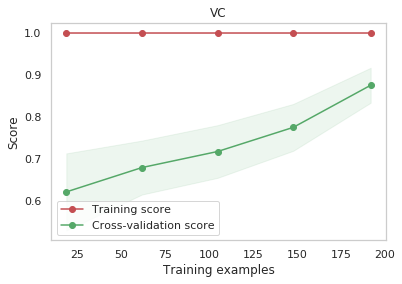

In [256]:
# Plotting Validation Curves todo

def plot_learning_curve(estimator, title, X, y, ylim=None, cv=None, n_jobs=None, 
                        train_sizes=np.linspace(.1, 1.0, 5)):
    plt.figure()
    plt.title(title)
    if ylim is not None:
        plt.ylim(*ylim)
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    train_sizes, train_scores, test_scores = learning_curve(
        estimator, X, y, cv=cv, n_jobs=n_jobs, train_sizes=train_sizes)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    plt.grid()
    plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                     train_scores_mean + train_scores_std, alpha=0.1,  color="r")
    plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                     test_scores_mean + test_scores_std, alpha=0.1, color="g")
    plt.plot(train_sizes, train_scores_mean, 'o-',
             color="r", label="Training score")
    plt.plot(train_sizes, test_scores_mean, 'o-',
             color="g", label="Cross-validation score")
    plt.legend(loc="best")
    return plt


# for key in models:
#     plot_learning_curve(models[key], key, X_train, y_train, cv=5)
plot_learning_curve(models['CART'], key, X_train, y_train, cv=5);

In [257]:
import sklearn
sklearn.__version__

'0.21.2'

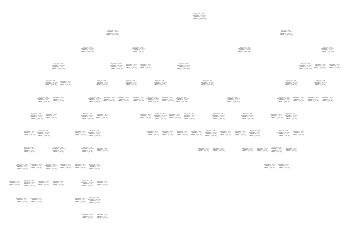

In [258]:
#### Hyper

### visual

from sklearn import tree
tree.plot_tree(models['CART'].fit(X_train, y_train));

In [259]:
import graphviz 
dot_data = tree.export_graphviz(models['CART'], out_file=None, feature_names=data_grp.columns[1:14], filled=True, rounded=True, special_characters=True) 
graph = graphviz.Source(dot_data) 
graph.render("iris") 

'iris.pdf'

## Discusstion

## References

In [260]:
key = 'RFC'
print('Confusion Matrix:')
print('='*80)
print(confusion_matrix(y_test, models[key].predict(X_test)))
print('='*80)
print('')
print('Classification Report:')
print('='*80)
print(classification_report(y_test, models[key].predict(X_test)))
print('='*80)
print('')
print('Classification Report:')
print('='*80)
print(key,'====',models[key].get_params())
print('='*80)

Confusion Matrix:
[[44  2]
 [ 6 29]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.96      0.92        46
           1       0.94      0.83      0.88        35

    accuracy                           0.90        81
   macro avg       0.91      0.89      0.90        81
weighted avg       0.90      0.90      0.90        81


Classification Report:
RFC ==== {'bootstrap': True, 'class_weight': None, 'criterion': 'gini', 'max_depth': None, 'max_features': 'auto', 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': None, 'verbose': 0, 'warm_start': False}


1 1.0 1.0
2 1.0 1.0
3 1.0 1.0
4 1.0 1.0
5 1.0 1.0
6 1.0 1.0
7 1.0 1.0
8 1.0 1.0
9 1.0 1.0
10 1.0 1.0
11 1.0 1.0
12 1.0 1.0
13 1.0 1.0
14 1.0 1.0
15 1.0 1.0
16 1.0 1.0
17 1.0 1.0
18 1.0 1.0
19 1.0 1.0
20 1.0 1.0
21 1.0 1.0
22 1.0 1.0
23 1.0 1.0
24 1.0 1.0
25 1.0 1.0
26 1.0 1.0
27 1.0 1.0
28 1.0 1.0


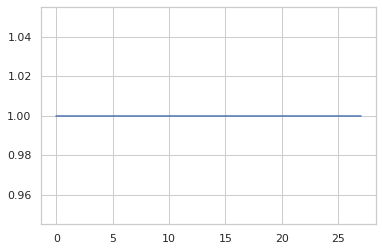

In [261]:
from sklearn.feature_selection import SelectKBest, chi2
cv_m = []
cv_acc = []
X, y = data_grp.values[:, 1:], data_grp.values[:, 0]   
for i in range(1,data.shape[1]): 
    ch2=SelectKBest(chi2, k=i)
    X_f = ch2.fit_transform(X, y)
    X_train, X_test, y_train, y_test = train_test_split(X_f, y)
    m_f = RandomForestClassifier(n_estimators=100)
    m_f.fit(X_train, y_train)
    cv_score = cross_val_score(m_f, X_train, y_train, scoring="accuracy", cv=kfold)
    cv_means = round(cv_score.mean(), 2)
    #     cv_std = round(cv_score.std(), 2)
    acc_score = round(m_f.score(X_test, y_test), 2)
    cv_m.append(cv_means)
    cv_acc.append(acc_score)
    print(i, cv_means, acc_score)

plt.plot(range(28), cv_m)


In [262]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
testchi = chi2(X, y)
test = SelectKBest(score_func=chi2, k=10)
fit = test.fit(X, y)
print(fit.scores_)
features = fit.transform(X)
test.get_support()
print(test.get_support())
data_grp.columns

[nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
[False False False False False False False False False False False False
 False False False False False False  True  True  True  True  True  True
  True  True  True  True]


Index(['GRP', 'AGE', 'SEX', 'CUL', 'PRO', 'INC', 'LOC', 'SEL', 'SRC', 'REA',
       'WIL', 'PAY', 'CHI', 'REL', 'IHE', 'IAP', 'INU', 'IIN', 'ILO', 'IRE',
       'IME', 'ICA', 'IFR', 'IAC', 'IIN.1', 'IST', 'IFA', 'IPO', 'ICI'],
      dtype='object')

In [263]:
from sklearn.ensemble import ExtraTreesClassifier
model = ExtraTreesClassifier(n_estimators=100)
fit = model.fit(X, y)
print(fit.feature_importances_)

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
